# Proyecto 4

**GITHUB link**: https://github.com/GDistel/NLP_product_reviews

**ATENCION**: Descargar archivo X.csv de carpeta de Google Drive (GitHub no lo acepta por ser muy pesado): https://drive.google.com/drive/folders/1Y2bpu_Gu9q7nu93rYOE054-g0_eOPKOg?usp=sharing

En éste último proyecto, vamos a continuar el trabajo que veníamos realizando en el proyecto 3.

El objetivo es: **Optimizar el modelo del problema binario (calificación positiva 1 y calificación negativa 0)**

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Objetivo: Optimizar el modelo del problema binario

En la última parte del proyecto 3, decidimos continuar con la sugerencia de transformar el problema multinómico de 5 clases (la evaluación en estrellas de 1 a 5) a un problema binario en donde la evaluación es positiva o negativa.

Para ésto, transformamos las categorías de la siguiente manera:
- Estrellas 1, 2, y 3 corresponden a la categoría de review negativa (0).
- Estrellas 4 y 5 corresponden a la categoría positiva (1).

Una exploración rápida demuestra que el accuracy aumenta considerablemente cuando las categorías a predecir son dos, por lo que ésto podría resultar una manera de redefinir el problema. Claro que, en una situación real, habría que ver si al cliente le sirve dicha redefinición.

In [2]:
# Cargado de datos

data_train = pd.read_csv('./DS_Proyecto_03_data_train_lemma.csv')
y = data_train.stars
X = pd.read_csv('./X.csv')

In [3]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Binificación de la variable objetivo

binify = lambda x: 1 if x > 3 else 0
y_train_bin = y_train.transform(binify)
y_test_bin = y_test.transform(binify)

# Cantidad de valores para 0 y 1

y_train_bin.value_counts()

0    96075
1    63925
Name: stars, dtype: int64

In [4]:
# Cantidad de valores para 0 y 1

y_test_bin.value_counts()

0    23925
1    16075
Name: stars, dtype: int64

In [5]:
# Modelo benchmark

clf_binary = LinearSVC(random_state = 42)
clf_binary.fit(X_train, y_train_bin)

y_test_pred_bin = clf_binary.predict(X_test)
accuracy_score(y_test_pred_bin, y_test_bin)

0.815425

El dataset ha quedado ahora ligeramente desbalanceado: 60% de los datos corresponden a la clasificación negativa mientras que 40% a la positiva. Ésta diferencia no parece ser muy importante por lo que, si bien podríamos adoptar diferentes estrategias para re-balancearlos (por ej. undersampling de la clase dominante), optamos por dejar las cosas como están.

Vamos a proceder a optimizar el modelo binario.

In [6]:
%%time

# Optimización

param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.01, 0.1, 0.5, 1.0, 1.1],
    'multi_class': ['ovr'],
}

clf = LinearSVC(random_state = 42, dual = False) # dual = False es preferible cuando n_samples > n_features
clf_opt = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, scoring = 'accuracy')

clf_opt.fit(X_train, y_train_bin)
clf_opt.best_params_

CPU times: user 10.9 s, sys: 11.4 s, total: 22.3 s
Wall time: 23min 18s


{'C': 0.5,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1',
 'tol': 0.0001}

In [7]:
y_test_pred = clf_opt.predict(X_test)
acc_clf_opt = accuracy_score(y_test_pred, y_test_bin)
print(f'Accuracy para LinearSVC optimizado: {acc_clf_opt}')

Accuracy para LinearSVC optimizado: 0.815625


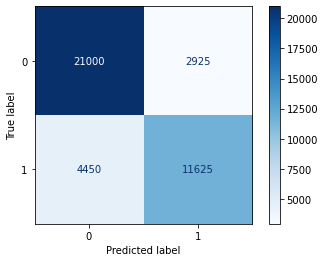

In [8]:
# Matriz de confusión

plot_confusion_matrix(clf_opt.best_estimator_, X_test, y_test_bin, cmap = plt.cm.Blues, values_format = '.0f')

### Conclusión

El accuracy obtenido es el mismo que el benchmark. Es decir, sucedió lo mismo que en el problema de 5 categorías en donde la optimización no aumentó el accuracy. Sin embargo, ésta continúa siendo buena. En términos simples: el clasificador acierta 4 de cada 5 veces en sus predicciones.

Con respecto a lo observado en la matriz de confusión: la categoría negativa se predice mejor que la positiva.

Observamos, en comparación con la optimización en el problema multiclase, que la fuerza de la regularización aumenta ('C'). Sin embargo, el resto de los hiperparámetros permanece igual, siguiendo también en línea con lo encontrado en el problema multiclase.

En una situación real, la última palabra la tendría el cliente. Podría sugerirse que momentáneamente se acepte esta solución binaria, y que se continúe intentando optimizar el problema multiclase.